In [1]:
#Importing Librairies
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import os.path

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense

In [2]:
# Define helper functions

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense
# Convert folder to dataframe of images' paths & labels
def get_paths_labels_train(path, allowed_extension="jpg"):
        global Path
        images_dir = Path(path)
        
        filepaths = pd.Series((images_dir.glob(fr'**/*.{allowed_extension}'))).astype(str)
        filepaths.name = "path"
        print('labels',type(filepaths.str.split("\\")[:].str[-2]))
        labels = filepaths.str.split("\\")[:].str[-2]
        labels.name = "label"
        # Concatenate filepaths and labels
        df = pd.concat([filepaths, labels], axis=1)

        # Shuffle the DataFrame and reset index
        df = df.sample(frac=1).reset_index(drop = True)
        return df
     

In [3]:
# Read image
def get_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [4]:
# Process image (input) for the model
def process(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    img = tf.keras.applications.mobilenet.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img


# Make classifications & visualize results
def visualize_classifications(model, datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)
    
    classes = np.array(list(datagen.class_indices))
    labels = classes[np.array(datagen.labels)[random_indexes]]
    filepaths = pd.Series(datagen.filenames)[random_indexes]
    
    images = filepaths.apply(get_image).reset_index(drop=True)
    processed_images = np.vstack(images.apply(process).to_numpy()[:])
    
    y_pred = classes[np.argmax(model.predict(processed_images, verbose=0), axis=1)]
    y_true = labels
    
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    
    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            ax[i,j].imshow(images[sample_index])
            ax[i,j].set_title(f"Y true({y_true[sample_index]}) | Y pred ({y_pred[sample_index]})")
            ax[i,j].set_axis_off()
    plt.show()

In [5]:
# Create dataframe of {paths, labels}
dataset = get_paths_labels_train('asl_alphabet_train')
#print('dataset',dataset)

labels <class 'pandas.core.series.Series'>


In [6]:
# Classes counts
print("Classes counts")
counts = dataset.iloc[:,1].value_counts().sort_index()
print(counts.head(counts.shape[0]))
print(f"\n\nDataset size = {counts.sum()} samples")   


Classes counts
A          3000
B          3000
C          3000
D          3000
E          3000
F          3000
G          3000
H          3000
I          3000
J          3000
K          3000
L          3000
M          3000
N          3000
O          3000
P          3000
Q          3000
R          3000
S          3000
T          3000
U          3000
V          3000
W          3000
X          3000
Y          3000
Z          3000
del        3000
nothing    3000
space      3000
Name: label, dtype: int64


Dataset size = 87000 samples


In [7]:
# Preprocess data

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    validation_split=0.2,
    horizontal_flip = True,
    brightness_range=(0.75, 1.3),
    zoom_range=0.2
)


train_images = train_generator.flow_from_dataframe(
    dataframe=dataset,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=dataset,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    subset='validation'
)

Found 69600 validated image filenames belonging to 29 classes.
Found 17400 validated image filenames belonging to 29 classes.


In [8]:
pretrainedModel = tf.keras.applications.MobileNet(
    input_shape=(224, 224, 3),
     include_top=False,
     weights='imagenet',
     pooling='avg'
)
pretrainedModel.trainable = False

inputs = pretrainedModel.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrainedModel.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(29, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer_adam = tf.keras.optimizers.Adam(learning_rate = 0.005)


In [9]:
# Compile model
model.compile(
    optimizer=optimizer_adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
# Fit model
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=2,
 )

Epoch 1/2
1088/1088 [==============================] - 3980s 4s/step - loss: 0.2549 - accuracy: 0.9206 - val_loss: 0.1862 - val_accuracy: 0.9413
Epoch 2/2
1088/1088 [==============================] - 3355s 3s/step - loss: 0.0974 - accuracy: 0.9687 - val_loss: 0.0740 - val_accuracy: 0.9770


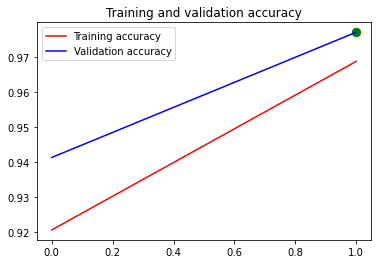

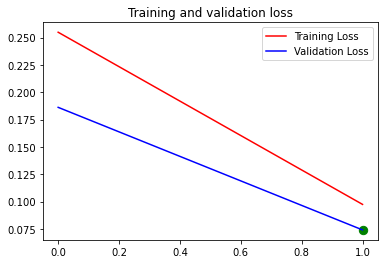

In [11]:
# Training & Validation <> Loss & Accuracy

%matplotlib inline
acc = np.array(history.history['accuracy'])
val_acc = np.array(history.history['val_accuracy'])
loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

epochs = np.arange(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.scatter(epochs[val_acc.argmax()], val_acc.max(), color='green', s=70)
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.scatter(epochs[val_loss.argmin()], val_loss.min(), color='green', s=70)
plt.title('Training and validation loss')
plt.legend()

plt.show()

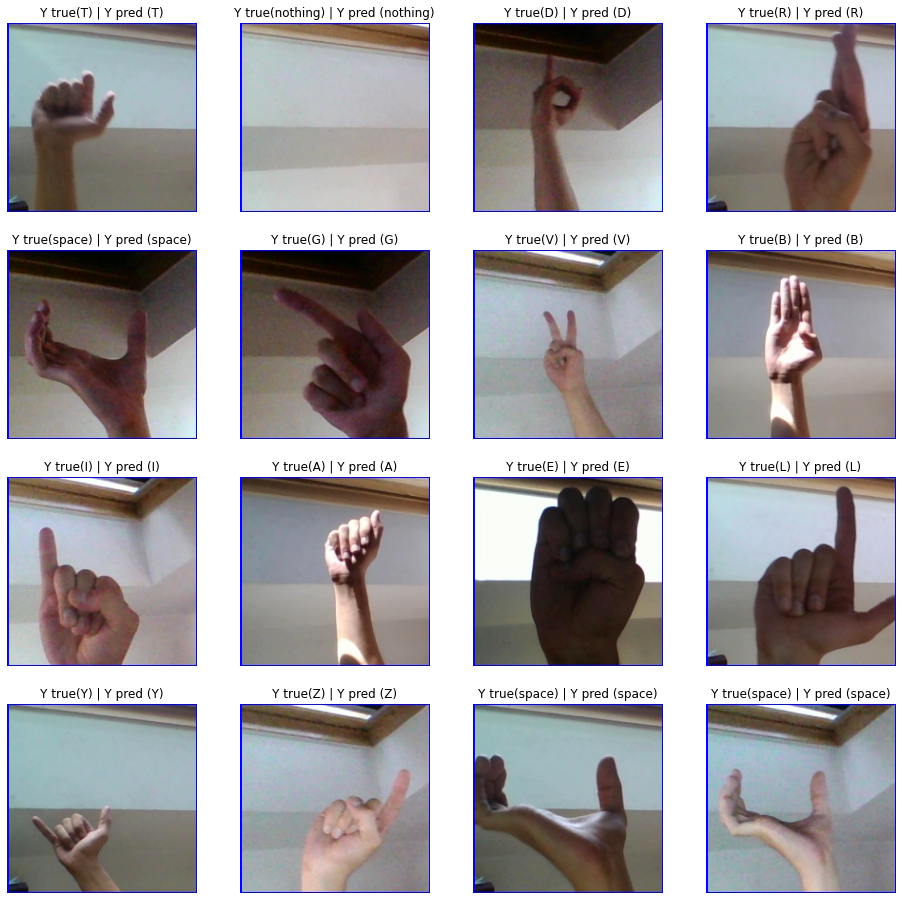

In [15]:
visualize_classifications(model, val_images)

In [14]:
#model.save('action.h5')
model.load_weights('action.h5')

## Testing

In [16]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pyttsx3
import pickle

In [27]:
model = tf.keras.models.load_model('action.h5')
model.summary()

#getting the labels form data directory
labels = sorted(os.listdir(r'asl_alphabet_test\asl_alphabet_test'))
print(labels)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

## Realtime capturing

In [101]:
from os import system, name  
from time import sleep
import cv2, queue, threading, time
from cv2 import CAP_PROP_BUFFERSIZE
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import clear_output
import os
import time
char=[]

# bufferless VideoCapture
class VideoCapture:
    def __init__(self, name):
        self.cap = cv2.VideoCapture(name)
        self.q = queue.Queue()
        t = threading.Thread(target=self._reader)
        t.daemon = True
        t.start()
    
    def _reader(self):
        while True:
            ret, frame = self.cap.read()
            if not ret:
                break
            if not self.q.empty():
                try:
                    self.q.get_nowait()
                except queue.Empty:
                    pass
            self.q.put(frame)
    
    def read(self):
        return self.q.get()


cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_BUFFERSIZE,3)

while(True):
    time.sleep(5)
    try:
    
        _ , frame = cap.read()
        cv2.rectangle(frame, (100, 100), (300, 300), (0, 0, 255), 5) 
        #region of intrest
        roi = frame[100:300, 100:300]
        img = cv2.resize(roi, (224, 224))
        cv2.imshow('roi', roi)

        img = img/255

        #make predication about the current frame
        prediction = model.predict(img.reshape(1,224,224,3))
        char_index = np.argmax(prediction)

        confidence = round(prediction[0,char_index]*100, 1)
        predicted_char = labels[char_index]

        if predicted_char == 'nothing':
            predicted_char =' '
            
        font = cv2.FONT_HERSHEY_TRIPLEX
        fontScale = 1
        color = (0,255,255)
        thickness = 2

            
        char.append(predicted_char[0])
        print(''.join(char))
        msg = predicted_char +',: ' +str(''.join(char))
        cv2.putText(frame, msg, (80, 80), font, fontScale, color, thickness)   

        cv2.imshow('frame',frame)
        
        sleep(1)

    
    except:
        pass
    
    #close the camera when press 'q'
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
        
#release the camera and close all windows
cap.release()
cv2.destroyAllWindows()

I
I 
I A
I AM
I AM 
I AM A
I AM AN
I AM ANJ
I AM ANJU
